In [1]:
from __future__ import print_function
import sys
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm
os.chdir("/usr/src/app")

In [2]:
def path_video(video_id):
    return f'videos/{video_id}.mp4'

def capture_frame(cap, frame_num):
    frame = get_frame(cap, frame_num)
    return frame

def get_video(video_path):
    return cv2.VideoCapture(video_path)

def get_frame(cap, frame_num):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    
    # Read the frame
    ret, frame = cap.read()

    return frame

def get_total_frames(cap):
    # Get the total number of frames in the video
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return frames

def get_fps_video(cap): 
    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    return fps

def plot_frames_grid(frames, nrows, ncols, size=(14, 11)):
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=size)
    
    # Add content to each subplot (replace this with your data)
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            frame = frames[idx]
            ax = axes[i, j]
            ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            idx += 1
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()


def plot_frame(frame, size=(14,11)):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=size)
    
    # Display the frame
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return fig, ax

def plot_net(ax, net_points, frame):
    # Draw the net (rectangle) on the frame in green
    net_points = np.array(net_points, dtype=int)
    cv2.polylines(frame, [net_points], isClosed=True, color=(0, 255, 0), thickness=2)
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return ax

def plot_court(ax, court_points):
    # Extract court points and scatter them as black points
    court_points = np.array(court_points, dtype=int)
    ax.scatter(court_points[:, 0], court_points[:, 1], c='black', s=5)
    return ax

def get_patch(image, court_points, idx, w = 25):
    kp = court_points[idx]
    x,y = kp
    x = int(x); y = int(y)
    patch = image[y-w:y+w, x-w:x+w, :]
    return patch

def patch_image(image, center, w=(25, 25)):
    x,y = center
    wx, wy = w
    x = int(x); y = int(y)
    patch = image[y-wy:y+wy, x-wx:x+wx, :]
    return patch

def match_patch(img, patch, window_template, loc_at_center=True):
    # Template matching
    match_method = cv2.TM_SQDIFF
    result = cv2.matchTemplate(img, patch, match_method)

    # Find the minimum value (best match) and its location
    # this is the top left corner of the box
    min_val, _, min_loc, _ = cv2.minMaxLoc(result)
    
    # Subtract the width to all tuple elements since we convert
    # top left into the center of the patch
    if loc_at_center:
        match_loc = op_tuples(min_loc, window_template)
    else:
        match_loc = min_loc
    
    return match_loc, min_val

def wrap_match_patch(img, patch, ii):
    return match_patch(img, patch), ii

def eval_match_patch(match_loc, true_loc):
    # Convert the float target center of the patch into integers
    true_loc = tuple(map(lambda x: int(x), true_loc))
    return mse(true_loc, match_loc)

def match_all_patches(img, patches):
    d_match_loc = {}
    with ThreadPoolExecutor(len(patches)) as executor:
        pool_res = [executor.submit(wrap_match_patch, img, patch, idx_patch) for idx_patch, patch in enumerate(patches)]
        for future_res in as_completed(pool_res):
            res_match_patch, idx_patch = future_res.result()
            d_match_loc[idx_patch] = res_match_patch
    return d_match_loc

def op_tuples(tuple1, tuple2, op="add"):
    if op == "add":
        result = tuple(x + y for x, y in zip(tuple1, tuple2))
    elif op == "subtract":
        result = tuple(x - y for x, y in zip(tuple1, tuple2))
    else:
        result = None
    return result

def draw_circle(img, pos, plot=True):
    x_img = img.copy()
    color = (0, 0, 255)
    size = 10
    x_img = cv2.circle(x_img, pos, size, color, -1)
    if plot:
        plot_frame(x_img, size=(8,3))
        return
    return x_img

def from_bgr_to_pil(img):
    # Load and preprocess the first image
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb_img)
    return pil

def get_roi(image, frac_start = 1./6, frac_end = 1./6):
    # Define the region of interest (ROI)
    H, W, _ = image.shape
    roi_start_h = int(H * frac_start)
    roi_end_h = int(H * frac_end)
    roi_start_w = int(W * frac_start)
    roi_end_w = int(W * frac_end)
    return roi_start_h, roi_end_h, roi_start_w, roi_end_w

def get_roi_xy(image, fx_s = 1./6, fx_e = 2./6, fy_s = 1./6, fy_e = 2./6):
    # Define the region of interest (ROI)
    H, W, _ = image.shape
    roi_start_h = int(H * fy_s)
    roi_end_h = int(H * fy_e)
    roi_start_w = int(W * fx_s)
    roi_end_w = int(W * fx_e)
    return roi_start_h, roi_end_h, roi_start_w, roi_end_w

def get_mask_xy(image, fx_s = 1./6, fx_e = 2./6, fy_s = 1./6, fy_e = 2./6):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi(image,fx_s, fx_e, fy_s, fy_e)
    # Create a mask for the ROI
    mask = np.zeros((H, W), dtype=np.uint8)
    mask[sh:eh, sw:ew] = 255
    return mask

def get_image_mask_xy(image, fx_s, fx_e, fy_s, fy_e):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi_xy(image, fx_s, fx_e, fy_s, fy_e)
    patch = image[sh:eh, sw:ew]
    return patch

def get_mask(image, frac_start, frac_end):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi(image, frac_start, frac_end)
    # Create a mask for the ROI
    mask = np.zeros((H, W), dtype=np.uint8)
    mask[sh:eh, sw:ew] = 255
    return mask

def get_image_mask(image, frac_start, frac_end):
    H, W, _ = image.shape
    sh, eh, sw, ew = get_roi(image, frac_start, frac_end)
    patch = image[sh:eh, sw:ew]
    return patch

def get_hist(image):
    # Compute the histogram
    f_hist = cv2.calcHist(
        images=[image], 
        channels=[0], 
        mask=None, 
        histSize=[30], 
        ranges=[0, 180]
    )
    return f_hist.ravel()

def get_hist_on_patch_masked(image, f1, f2):
    # Convert BGR image to HSV format
    hsv_f_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Generate a mask
    f_mask = get_mask(image, f1, f2)
    
    # Compute the histogram
    f_hist = cv2.calcHist(
        images=[hsv_f_img], 
        channels=[0], 
        mask=f_mask, 
        histSize=[30], 
        ranges=[0, 180]
    )
    return f_hist.ravel()
    
def patch_similarity(patch1, patch2):
    patch1_hist = get_hist(patch1)
    patch2_hist = get_hist(patch2)
    
    # Calculate the Bhattacharyya coefficient
    bc = cv2.compareHist(patch1_hist, patch2_hist, cv2.HISTCMP_BHATTACHARYYA)
    return bc

def patch_similarity_on_template(q_patch, t_hist):
    patch_q_hist = get_hist(q_patch)
    
    # Calculate the Bhattacharyya coefficient
    bc = cv2.compareHist(t_hist, patch_q_hist, cv2.HISTCMP_BHATTACHARYYA)
    return bc

def generate_patches_of_image(image, patches_fractions):
    """
        patches_fractions: includes a tuple (frac_x_start, frac_x_end, frac_y_start, frac_y_end)
    """
    l_fr = []
    for ii in range(len(patches_fractions)):
        fxs, fxe, fys, fye = patches_fractions[ii]
        fr = get_image_mask_xy(image, fxs, fxe, fys, fye)
        l_fr.append(fr)
    return l_fr

def get_bc_conf(list_of_bc_coefficients):
    """
    We will input a list of N elements
    These elements are the patch_similarity_on_template outputs
    These outputs are the similarities of the N patches of query 
    compared to the corresponding patch on the reference image.
    We set two thresholds for the Bhattacharyya coefficients:
    - High (0.3): if the BC coefficient of the comparison
        of the query to the reference of that patch is <0.3
        then we will +1 to the final confidence
    - Low (0.5): if the BC coefficient of the comparison
        of the query to the reference of that patch is <0.5
        then we will +1 to the final confidence
    Since we have N=4 patches, and two thresholds, we
    can opt for a confidence at most of 8 and at minimum of 0
    A confidence of 8 indicates super similar query to reference image in all patches
    """
    THRES_BC_HIGH_CONF = 0.3
    THRES_BC_LOW_CONF = 0.5
    l_bc = np.array(list_of_bc_coefficients)
    n_match_low_conf = np.sum(l_bc < THRES_BC_LOW_CONF)
    n_match_high_conf = np.sum(l_bc < THRES_BC_HIGH_CONF)
    confidence = n_match_low_conf + n_match_high_conf
    return confidence

# Read annotations

In [3]:
PATH_ANNOTATIONS_REFERENCE_PARQUET = "annotations/reference_courts/annotations.parquet"
dfannot = pd.read_parquet(PATH_ANNOTATIONS_REFERENCE_PARQUET, engine="pyarrow")

# Select Reference court

In [4]:
tournament_id = 4  # Indian Wells

In [5]:
# Get the reference court points and net points at the given frame number
s = dfannot.loc[dfannot["tournament_id"] == tournament_id].reset_index(drop=True).loc[0]

video_id = s.video_id  # "DhnpBjrgb34"
path = path_video(video_id)
frame_num = s.frame_id
court_points = np.vstack(s.court)
net_points = np.vstack(s.net)
print(f"Video: {video_id}, Frame: {frame_num}, Path: {path}")

Video: fnK4I6k9eHs, Frame: 29533, Path: videos/fnK4I6k9eHs.mp4


### Load frame of reference court

In [6]:
# Open the video file
cap = cv2.VideoCapture(path)

# Load reference frame
t_img = capture_frame(cap, frame_num)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

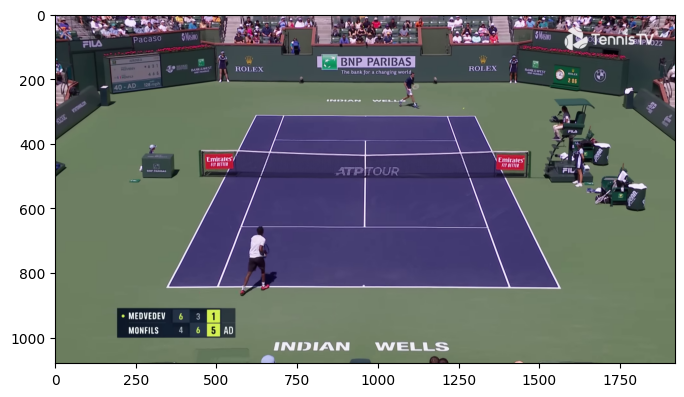

In [7]:
plot_frame(t_img, size=(8,8))

# Select Query court

In [8]:
q_video_id = "jGAMZKj6Ceo"
q_path = path_video(q_video_id)

# Open the video file
cap = cv2.VideoCapture(q_path)

# Get FPS
q_fps = get_fps_video(cap)

# Cosine similarities
# 36s: 0.9564
# 37.8s: 0.9396
# 39.8s: 0.8639 (Sinner image)
 

q_second = 37.8   # 37.8 OK # 36 OK
q_frame_num = int(q_second * q_fps)

In [9]:
# Load query frame
q_img = capture_frame(cap, q_frame_num)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

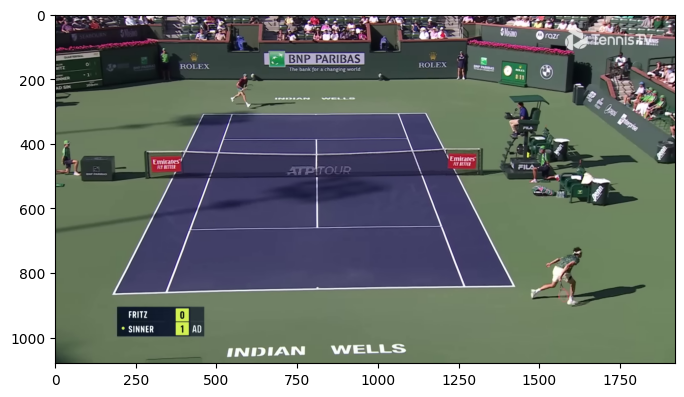

In [10]:
plot_frame(q_img, size=(8,8))

# Histogram Functions

### Patch both images in 4 sub images

In [11]:
# ------------------- #
#  Patches of image
# ------------------- #
fs = [
    (1./7, 1./2, 1./7, 1./2), 
    (1./2, 6./7,  1./7, 1./2),
    (1./7, 1./2, 1./2, 6./7),
    (1./2, 6./7, 1./2, 6./7),  
]

(<Figure size 800x800 with 1 Axes>, <Axes: >)

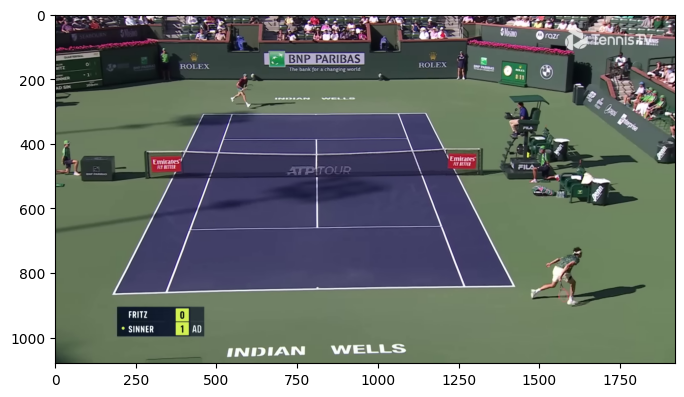

In [12]:
plot_frame(q_img, size=(8,8))

In [13]:
patches_t_img = generate_patches_of_image(t_img, fs)
patches_q_img = generate_patches_of_image(q_img, fs)

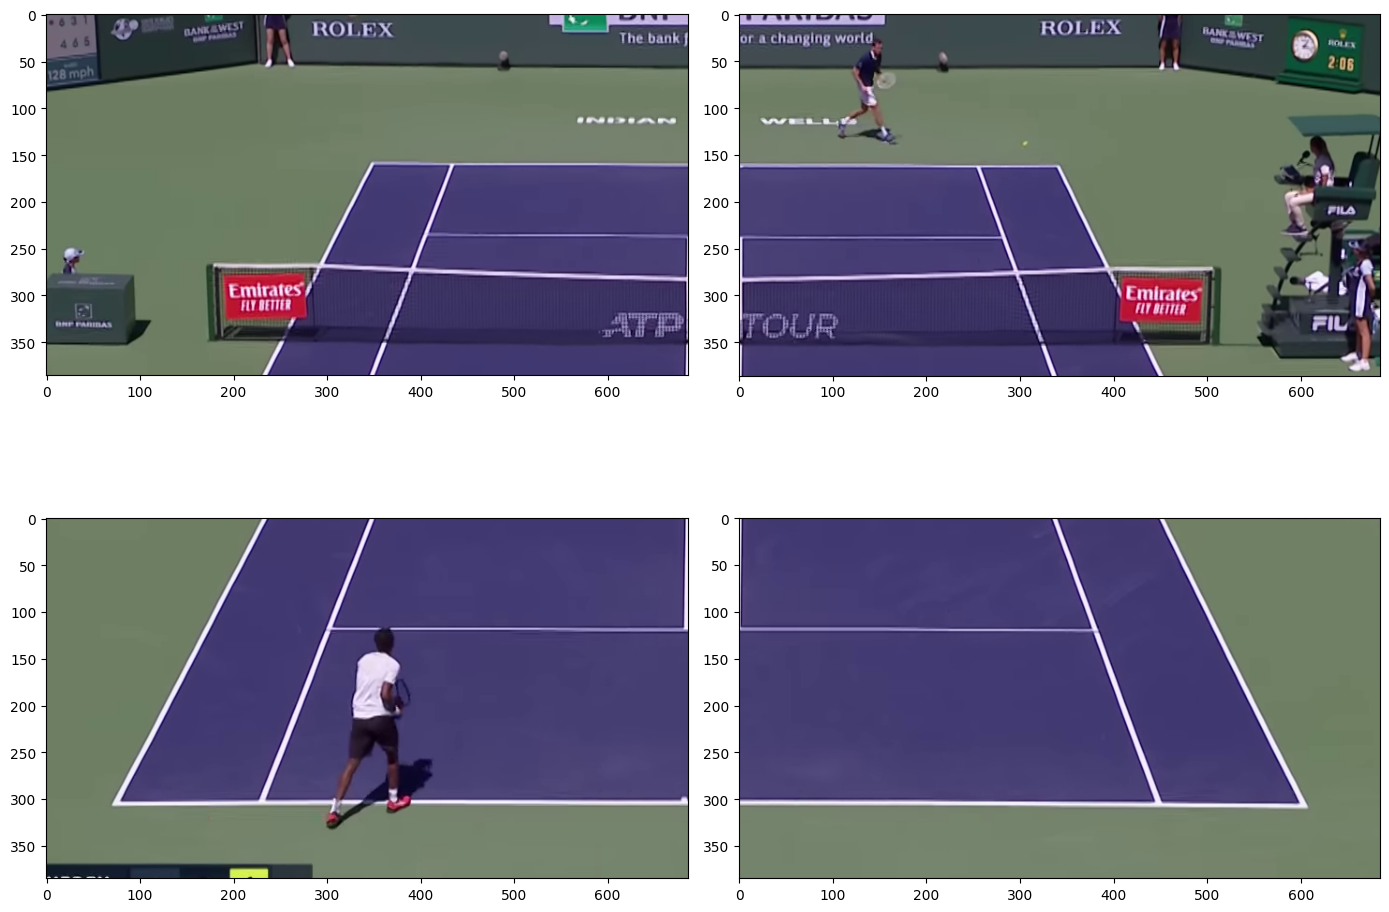

In [14]:
plot_frames_grid(patches_t_img, 2, 2)

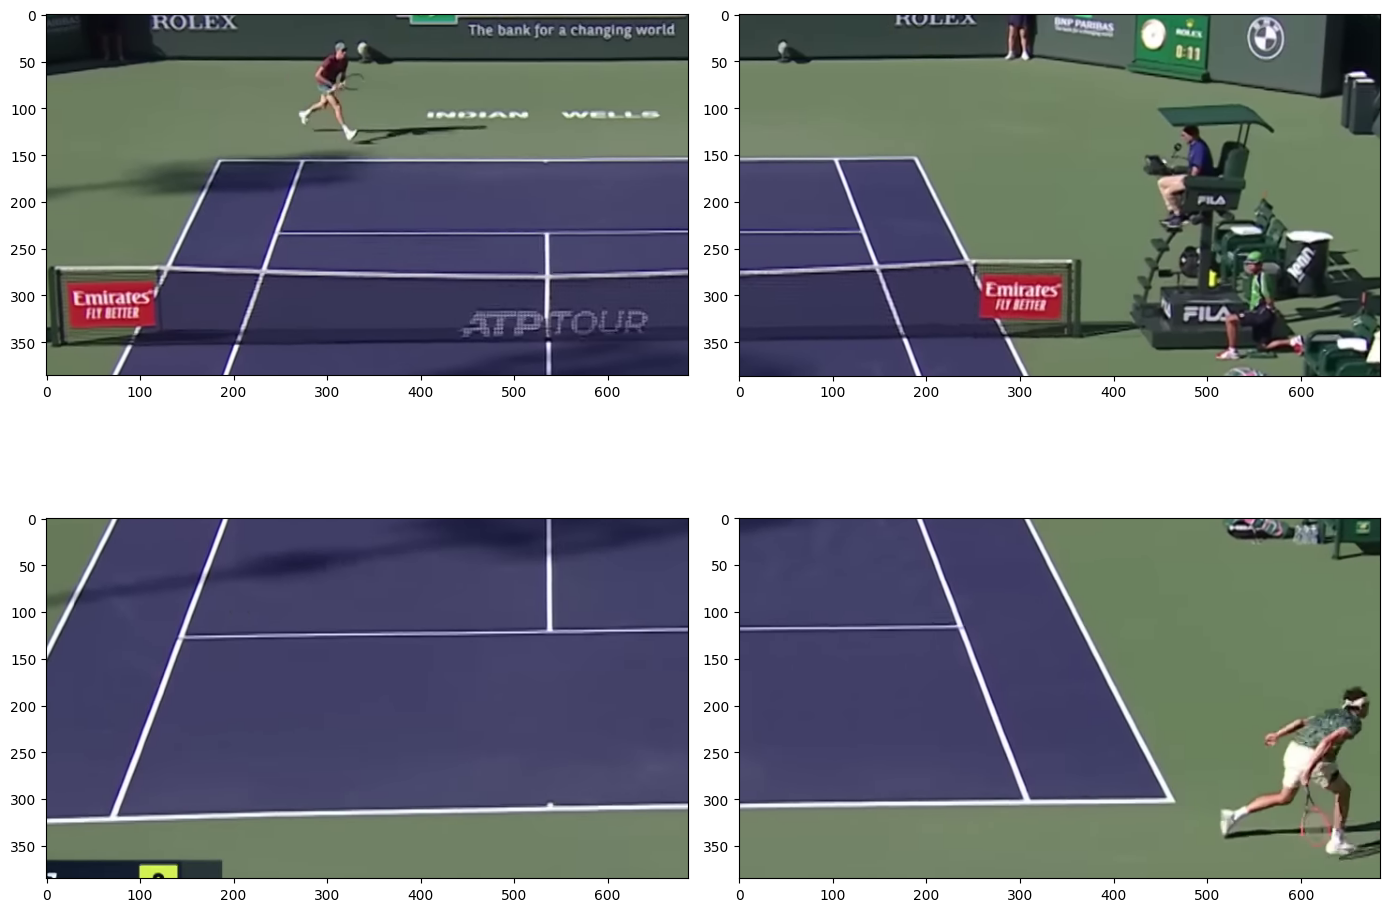

In [15]:
plot_frames_grid(patches_q_img, 2, 2)

### Compare each query patch to the reference template patch

In [16]:
%%time
l_bc = []
for idx in range(len(patches_q_img)):
    bc = patch_similarity(patches_t_img[idx], patches_q_img[idx])
    l_bc.append(bc)

CPU times: user 4.11 ms, sys: 1.97 ms, total: 6.08 ms
Wall time: 4 ms


In [17]:
confidence = get_bc_conf(l_bc)

In [18]:
confidence

3

# Putting all Together

In [19]:
# ---------------------- #
# Inputs
# ---------------------- #
tournament_id = 4  # Indian Wells
q_video_id = "jGAMZKj6Ceo" # "DhnpBjrgb34"

In [20]:
# ------------------- #
#  Constants
# ------------------- #
# Fraction (H and W) to create patches of image
fs = [
    # frac_x_start, frac_x_end, frac_y_start,
    (1./7, 1./2, 1./7, 1./2), 
    (1./2, 6./7,  1./7, 1./2),
    (1./7, 1./2, 1./2, 6./7),
    (1./2, 6./7, 1./2, 6./7),  
]

In [21]:
# ---------------------- #
# Annotations
# ---------------------- #
PATH_ANNOTATIONS_REFERENCE_PARQUET = "annotations/reference_courts/annotations.parquet"
dfannot = pd.read_parquet(PATH_ANNOTATIONS_REFERENCE_PARQUET, engine="pyarrow")

# Get the reference court points and net points at the given frame number
s = dfannot.loc[dfannot["tournament_id"] == tournament_id].reset_index(drop=True).loc[0]

# Reference params
video_id = s.video_id; path = path_video(video_id); frame_num = s.frame_id; court_points = np.vstack(s.court); net_points = np.vstack(s.net)

# Get cap for reference image (template)
t_cap = get_video(path)

# Load reference frame
t_img = capture_frame(t_cap, frame_num)

# Patch reference frame
patches_t_img = generate_patches_of_image(t_img, fs)

# Histogram of Hue colors of reference frame
l_t_hist = [get_hist(ii_patch) for ii_patch in patches_t_img]

In [22]:
# ---------------------- #
# Query Video
# ---------------------- #
q_path = path_video(q_video_id)

# Get cap for reference image (template)
q_cap = get_video(q_path)

# Total frames
tot_frames = get_total_frames(q_cap)

# FPS
q_fps = int(get_fps_video(q_cap))

# Analyze frames at every 0.5 secs
l_q_frames = np.arange(0, tot_frames, q_fps//2).astype(int)

### Compare specific frames

In [23]:
# ------------------------------------ #
# Query: Iterate on frames
# ------------------------------------ #
# Select a second
q_second = 36   # 37.8 OK # 36 OK
q_frame_num = int(q_second * q_fps)
q_frame_num = 2310

# Load query frame
q_img = capture_frame(q_cap, q_frame_num)

# Generate patches
patches_q_img = generate_patches_of_image(q_img, fs)

In [26]:
%%time
# ------------------------------------ #
# Similarity: Query - Template
# ------------------------------------ #
# Bhattacharyya coefficients (BC)
l_bc = []
for idx in range(len(patches_q_img)):
    bc = patch_similarity_on_template(patches_q_img[idx], l_t_hist[idx])
    l_bc.append(bc)

CPU times: user 3.53 ms, sys: 47 µs, total: 3.58 ms
Wall time: 2.52 ms


In [27]:
confidence = get_bc_conf(l_bc)

In [28]:
l_bc

[0.6957699076698851,
 0.5374455470775528,
 0.7580688864092058,
 0.8067623640658017]

In [29]:
confidence

0

(<Figure size 700x700 with 1 Axes>, <Axes: >)

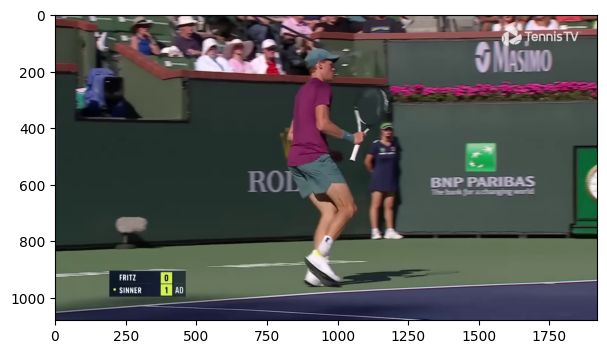

In [30]:
plot_frame(q_img, size=(7,7))

(<Figure size 700x700 with 1 Axes>, <Axes: >)

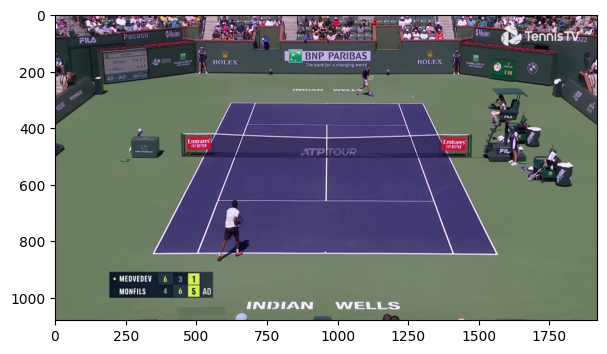

In [31]:
plot_frame(t_img, size=(7,7))

### Compare all frames

In [761]:
d_frames_confidence = {}
for q_frame_num in tqdm.tqdm(l_q_frames):

    # Load query frame
    q_img = capture_frame(q_cap, q_frame_num)

    # Generate patches
    patches_q_img = generate_patches_of_image(q_img, fs)

    # Bhattacharyya coefficients (BC)
    l_bc = []
    for idx in range(len(patches_q_img)):
        bc = patch_similarity_on_template(patches_q_img[idx], l_t_hist[idx])
        l_bc.append(bc)

    # Get confidence
    confidence = get_bc_conf(l_bc)

    # Persist it 
    d_frames_confidence[q_frame_num] = confidence

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [02:21<00:00,  3.59it/s]


In [762]:
# Convert the dictionary to a DataFrame
df_conf = pd.DataFrame(list(d_frames_confidence.items()), columns=['frame_num', 'confidence'])

In [778]:
# Create a mask to identify rows where confidence > 2
confidence_mask = df_conf['confidence'] > 2

# Use the shift function to compare consecutive rows
consecutive_mask = confidence_mask & confidence_mask.shift(-1)

# Extract frame_num values where all consecutive rows have confidence > 2
df_conf_final = df_conf.loc[consecutive_mask].copy()

# Deleted scenes
df_cut = df_conf.loc[~consecutive_mask].copy()

In [38]:
from torchvision.io import VideoReader

# stream indicates if reading from audio or video
reader = VideoReader(q_path, stream='video')

RuntimeError: Not compiled with video_reader support, to enable video_reader support, please install ffmpeg (version 4.2 is currently supported) andbuild torchvision from source.

In [ ]:

# can change the stream after construction
# via reader.set_current_stream

# to read all frames in a video starting at 2 seconds
for frame in reader.seek(2):
    # frame is a dict with "data" and "pts" metadata
    print(frame["data"], frame["pts"])

# because reader is an iterator you can combine it with
# itertools
from itertools import takewhile, islice
# read 10 frames starting from 2 seconds
for frame in islice(reader.seek(2), 10):
    pass
    
# or to return all frames between 2 and 5 seconds
for frame in takewhile(lambda x: x["pts"] < 5, reader.seek(2)):
    pass

In [818]:


# List of frame numbers to load
frame_numbers = [0, 10, 20]  # Modify this list as needed

# Create a VideoFrameDataset
video_dataset = video_utils.VideoFrameDataset(q_path, frame_indices=frame_numbers, num_segments=1, transform=None)



AttributeError: module 'torchvision.datasets.video_utils' has no attribute 'VideoFrameDataset'

In [ ]:
# Create a DataLoader to iterate through the frames
data_loader = torch.utils.data.DataLoader(video_dataset, batch_size=len(frame_numbers), shuffle=False, num_workers=0)

# Iterate through the DataLoader to get the frames
for batch in data_loader:
    frames = batch